In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import requests
from urllib.request import urlopen, Request
import time
from itertools import chain
from urllib.parse import quote 
import torch
from datasets import ClassLabel
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
import warnings
import nltk
from nltk.corpus import stopwords
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

stop_words = stopwords.words('english')

In [4]:
poke_df = pd.read_pickle('poke_df.pkl')

Create a dataframe for the opening paragraph for each Pokémon's Biology on Bulbapedia.

In [208]:
bulba_df = pd.DataFrame()
poketext = []
for pokemon in poke_df.Pokemon.unique():
    # print(pokemon)
    
    if pokemon == 'Ho-oh':
        pokemon = 'Ho-Oh'
    response = requests.get(f'https://bulbapedia.bulbagarden.net/wiki/{quote(pokemon)}', headers={"User-Agent":"Mozilla/5.0"})
    if response.status_code == 200:
        url = f'https://bulbapedia.bulbagarden.net/wiki/{quote(pokemon)}'
        pass
    else:
        # try just the first word
        if requests.get(
            f'https://bulbapedia.bulbagarden.net/wiki/{pokemon.split()[0]}', headers={"User-Agent":"Mozilla/5.0"}
            ).status_code == 200:
            pokemon = pokemon.split()[0]
            url = f'https://bulbapedia.bulbagarden.net/wiki/{pokemon.split()[0]}'
            
        elif requests.get(
            f'https://bulbapedia.bulbagarden.net/wiki/{"_".join([x for x in pokemon.split()])}'
            , headers={"User-Agent":"Mozilla/5.0"}
            ).status_code == 200:
            url = f'https://bulbapedia.bulbagarden.net/wiki/{"_".join([x for x in pokemon.split()])}'

        elif requests.get(
            f'https://bulbapedia.bulbagarden.net/wiki/{"_".join([x for x in quote(pokemon).split()])}'
            , headers={"User-Agent":"Mozilla/5.0"}
            ).status_code == 200:
            url = f'https://bulbapedia.bulbagarden.net/wiki/{"_".join([x for x in quote(pokemon).split()])}'

    current_description = []
    req = Request(url , headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    page_soup = BeautifulSoup(webpage, "html.parser")
    for tag in page_soup.find_all('h2')[1:]:
        if tag.text.strip() == 'Biology':
            for item in tag.find_next_siblings('p'):
                if 'Biology' in item.find_previous_siblings('h2')[0].text.strip():
                    current_description.append(item.text.strip().replace(pokemon,''))
    if current_description:                
        poketext.append(current_description[0])
    else:
        poketext.append([])
bulba_df['Pokemon'] = poke_df.Pokemon.unique()
bulba_df['Description'] = poketext
    
        

In [209]:
bulba_df

,Pokemon,Description
0,Bulbasaur,"is a small, quadrupedal amphibian Pokémon tha..."
1,Ivysaur,is a quadrupedal amphibian Pokémon that has b...
2,Venusaur,"is a squat, quadrupedal amphibian Pokémon wit..."
3,Charmander,"is a bipedal, reptilian Pokémon with a primar..."
4,Charmeleon,"is a bipedal, reptilian Pokémon. It has dark ..."
...,...,...
1003,Chi-Yu,is a fish-like Pokémon. It is composed of two...
1004,Roaring Moon,"is a quadrupedal, draconic Pokémon with a lon..."
1005,Iron Valiant,[]
1006,Koraidon,Apex Build is a large reptilian Pokémon. Most...


Some blanks. Let's fix this...

In [211]:
requests.get(f'https://bulbapedia.bulbagarden.net/wiki/{"Tapu_Koko"}').status_code

200

In [226]:
blank_pokes = []
for poke in list(bulba_df[bulba_df['Description'].astype(str) == '[]'].Pokemon):
    if requests.get(f'https://bulbapedia.bulbagarden.net/wiki/{"_".join([x for x in poke.split()])}').status_code == 200:
        url = f'https://bulbapedia.bulbagarden.net/wiki/{"_".join([x for x in poke.split()])}'
    current_description = []
    req = Request(url , headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    page_soup = BeautifulSoup(webpage, "html.parser")
    for tag in page_soup.find_all('h2')[1:]:
        if tag.text.strip() == 'Biology':
            for item in tag.find_next_siblings('p'):
                if 'Biology' in item.find_previous_siblings('h2')[0].text.strip():
                    current_description.append(item.text.strip().replace(pokemon,''))
    if current_description:                
        blank_pokes.append(current_description[0])

In [237]:
empty_pokemon = bulba_df[bulba_df['Description'].astype(str) == '[]'].Pokemon.index
for i in range(len(bulba_df[bulba_df['Description'].astype(str) == '[]'].Pokemon.index)):
    bulba_df.iloc[empty_pokemon[i],1] = blank_pokes[i]

In [239]:
bulba_df[bulba_df['Description'].astype(str) == '[]']

,Pokemon,Description


No more blanks. save the df

In [353]:
bulba_df.to_csv('bulba_df_valid.csv')

Load in previous stuff....

In [5]:
# create tokenizer from pretrained bert
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# establish int to pokemon relationship
class_converter = ClassLabel(num_classes = 1008, names = list(poke_df.Pokemon.unique()))


model1 = BertForSequenceClassification.from_pretrained(
    "pokemodel_apr_5",from_tf=False)

model2 = BertForSequenceClassification.from_pretrained(
    "pokemodel_apr_6",from_tf=False)

model3 = BertForSequenceClassification.from_pretrained(
    "pokemodel_apr17",from_tf=False)

model4 = BertForSequenceClassification.from_pretrained(
    "pokemodel_stopwords_1",from_tf=False)

Now let's test it out. In the final model, I ran it all over again, but filtered for stopwords. I'm curious if that will perform better than the best model before it. 

What we will do here is compare all four of these models AND a baseline of random choice Pokémon against two data sets

The first dataset is the first paragraph of each Pokemon's biology scraped off of Bublapedia. Bulbapedia is the only source online that I could find that I did not train the model on, so it shouldn't be perfectly predicting. 

The second dataset is where I asked random people to describe images of Pokémon. If this Pokedex was to work in real life, it would be used when a person observes a Pokemon and writes down what they see. Therefore, I had people write down what they see, and we will test if this model is more accurate than a baseline.

In [249]:
def predict_pokemon_(desc, model, filter_stopwords = False):

        
        for descriptor in ['Pokémon', 'Pokemon', 'pokemon','pokémon']:
            if descriptor in desc:
                desc = desc.replace(descriptor,'')
        if filter_stopwords:
            desc = ' '.join([word for word in desc.split() if word not in (stop_words)])

        
        pred_inputs = tokenizer(desc, return_tensors="pt")
    
        with torch.no_grad():

            logits = model(**pred_inputs).logits


            predicted_class_id = logits.argmax().item()
            second_class_id = torch.topk(logits.flatten(), 3).indices[1]
            third_class_id = torch.topk(logits.flatten(), 3).indices[2]

            first_pokemon = class_converter.int2str(predicted_class_id)
            second_pokemon = class_converter.int2str(second_class_id.item())
            third_pokemon = class_converter.int2str(third_class_id.item())

        return [first_pokemon, second_pokemon, third_pokemon]

In [260]:
bulba_df

,Pokemon,Description
0,Bulbasaur,"is a small, quadrupedal amphibian Pokémon tha..."
1,Ivysaur,is a quadrupedal amphibian Pokémon that has b...
2,Venusaur,"is a squat, quadrupedal amphibian Pokémon wit..."
3,Charmander,"is a bipedal, reptilian Pokémon with a primar..."
4,Charmeleon,"is a bipedal, reptilian Pokémon. It has dark ..."
...,...,...
1003,Chi-Yu,is a fish-like Pokémon. It is composed of two...
1004,Roaring Moon,"is a quadrupedal, draconic Pokémon with a lon..."
1005,Iron Valiant,"Iron Valiant is a mechanical, bipedal Pokémon ..."
1006,Koraidon,Apex Build is a large reptilian Pokémon. Most...


In [265]:
# baseline
bulba_df['baseline_preds'] = [random.choices(poke_df.Pokemon.unique(), k = 3) for x in range(len(bulba_df))]
# apr 5
bulba_df['V1_preds'] = bulba_df.Description.apply(lambda x: predict_pokemon_(x, model = model1))
# apr 6
bulba_df['V2_preds'] = bulba_df.Description.apply(lambda x: predict_pokemon_(x, model = model2))
# apr 17
bulba_df['V3_preds'] = bulba_df.Description.apply(lambda x: predict_pokemon_(x, model = model3))
# stopwords
bulba_df['V4_preds'] = bulba_df.Description.apply(lambda x: predict_pokemon_(x, model = model4, filter_stopwords= True))


In [276]:
bulba_df

,Pokemon,Description,V1_preds,V2_preds,V3_preds,V4_preds,baseline_preds
0,Bulbasaur,"is a small, quadrupedal amphibian Pokémon tha...","[Bulbasaur, Ivysaur, Butterfree]","[Ivysaur, Bulbasaur, Nincada]","[Bulbasaur, Ivysaur, Budew]","[Ivysaur, Bulbasaur, Grovyle]","[Vibrava, Pidgey, Wailord]"
1,Ivysaur,is a quadrupedal amphibian Pokémon that has b...,"[Ivysaur, Butterfree, Vileplume]","[Ivysaur, Vileplume, Weedle]","[Ivysaur, Budew, Bonsly]","[Ivysaur, Budew, Bonsly]","[Tentacruel, Drifblim, Kyogre]"
2,Venusaur,"is a squat, quadrupedal amphibian Pokémon wit...","[Bulbasaur, Ivysaur, Budew]","[Ivysaur, Bulbasaur, Budew]","[Ivysaur, Budew, Bulbasaur]","[Ivysaur, Bulbasaur, Budew]","[Yveltal, Klawf, Grafaiai]"
3,Charmander,"is a bipedal, reptilian Pokémon with a primar...","[Charmander, Vulpix, Salamence]","[Charmander, Vulpix, Charmeleon]","[Charmander, Charmeleon, Vulpix]","[Vulpix, Charmander, Charmeleon]","[Stoutland, Ursaluna, Seviper]"
4,Charmeleon,"is a bipedal, reptilian Pokémon. It has dark ...","[Azurill, Vulpix, Venomoth]","[Venomoth, Vulpix, Charmeleon]","[Charmeleon, Pinsir, Monferno]","[Pinsir, Charmeleon, Nidorino]","[Nymble, Victreebel, Golett]"
...,...,...,...,...,...,...,...
1003,Chi-Yu,is a fish-like Pokémon. It is composed of two...,"[Sableye, Tentacruel, Grumpig]","[Grumpig, Carbink, Reuniclus]","[Reuniclus, Carbink, Kommo-o]","[Chi-Yu, Roaring Moon, Diancie]","[Breloom, Abra, Roselia]"
1004,Roaring Moon,"is a quadrupedal, draconic Pokémon with a lon...","[Crobat, Fearow, Sneasel]","[Fearow, Crobat, Lanturn]","[Arcanine, Lugia, Empoleon]","[Mandibuzz, Empoleon, Golbat]","[Golurk, Grookey, Donphan]"
1005,Iron Valiant,"Iron Valiant is a mechanical, bipedal Pokémon ...","[Wurmple, Mareep, Farfetch'd]","[Tangrowth, Farfetch'd, Bellsprout]","[Decidueye, Doublade, Ceruledge]","[Gallade, Scyther, Mime Jr.]","[Fuecoco, Whimsicott, Hitmontop]"
1006,Koraidon,Apex Build is a large reptilian Pokémon. Most...,"[Masquerain, Spearow, Beedrill]","[Masquerain, Beedrill, Spearow]","[Rowlet, Talonflame, Corviknight]","[Koraidon, Corviknight, Aerodactyl]","[Grubbin, Hawlucha, Litten]"


In [289]:
bulba_df['baseline'] = bulba_df.apply(lambda row: int(row['Pokemon'] in row['baseline_preds']), axis = 1)
bulba_df['V1'] = bulba_df.apply(lambda row: int(row['Pokemon'] in row['V1_preds']), axis = 1)
bulba_df['V2'] = bulba_df.apply(lambda row: int(row['Pokemon'] in row['V2_preds']), axis = 1)
bulba_df['V3'] = bulba_df.apply(lambda row: int(row['Pokemon'] in row['V3_preds']), axis = 1)
bulba_df['V4'] = bulba_df.apply(lambda row: int(row['Pokemon'] in row['V4_preds']), axis = 1)

Now onto the annotations that I collected from real people

In [297]:
annotations = pd.read_excel('Pokemon_annotations.xlsx').drop(columns = ['Unnamed: 0'])

In [301]:
annotations.dropna(inplace = True)

In [303]:
# baseline
annotations['baseline_preds'] = [random.choices(poke_df.Pokemon.unique(), k = 3) for x in range(len(annotations))]
# apr 5
annotations['V1_preds'] = annotations.Annotation.apply(lambda x: predict_pokemon_(x, model = model1))
# apr 6
annotations['V2_preds'] = annotations.Annotation.apply(lambda x: predict_pokemon_(x, model = model2))
# apr 17
annotations['V3_preds'] = annotations.Annotation.apply(lambda x: predict_pokemon_(x, model = model3))
# stopwords
annotations['V4_preds'] = annotations.Annotation.apply(lambda x: predict_pokemon_(x, model = model4, filter_stopwords= True))

In [305]:
annotations['baseline'] = annotations.apply(lambda row: int(row['Pokemon'] in row['baseline_preds']), axis = 1)
annotations['V1'] = annotations.apply(lambda row: int(row['Pokemon'] in row['V1_preds']), axis = 1)
annotations['V2'] = annotations.apply(lambda row: int(row['Pokemon'] in row['V2_preds']), axis = 1)
annotations['V3'] = annotations.apply(lambda row: int(row['Pokemon'] in row['V3_preds']), axis = 1)
annotations['V4'] = annotations.apply(lambda row: int(row['Pokemon'] in row['V4_preds']), axis = 1)

In [372]:
annotations.to_csv('annotations.csv')

In [316]:
bulba_plotter = bulba_df[['Pokemon','baseline','V1','V2','V3','V4']]
annot_plotter = annotations[['Pokemon','baseline','V1','V2','V3','V4']]

In [313]:
bulba_plotter

,Pokemon,V1,V2,V3,V4
0,Bulbasaur,1,1,1,1
1,Ivysaur,1,1,1,1
2,Venusaur,0,0,0,0
3,Charmander,1,1,1,1
4,Charmeleon,0,1,1,1
...,...,...,...,...,...
1003,Chi-Yu,0,0,0,1
1004,Roaring Moon,0,0,0,0
1005,Iron Valiant,0,0,0,0
1006,Koraidon,0,0,0,1


Now, for some plots on the raw accuracy.

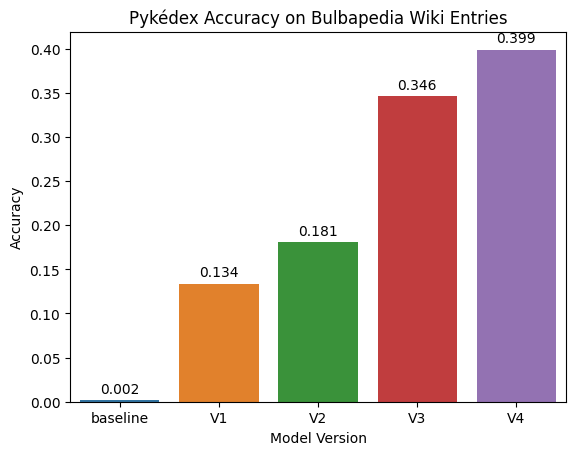

In [342]:

ax = sns.barplot(data = bulba_plotter, ci = None)
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f', padding=3)
plt.title('Pykédex Accuracy on Bulbapedia Wiki Entries')
plt.xlabel('Model Version')
plt.ylabel('Accuracy')
plt.show()

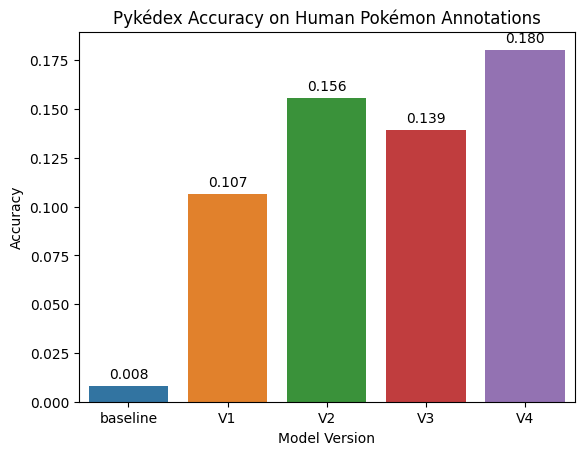

In [343]:

ax = sns.barplot(data = annot_plotter, ci = None)
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f', padding=3)
plt.title('Pykédex Accuracy on Human Pokémon Annotations')
plt.xlabel('Model Version')
plt.ylabel('Accuracy')
plt.show()

Finally, let's calculate some F1 scores!

In [369]:
f1_df = pd.DataFrame()
bulbaf1s = []
annotf1s = []
for model in ['baseline','V1','V2','V3','V4']:
    bulbaf1s.append(round(
        f1_score(bulba_plotter[model],np.ones(len(bulba_plotter)))
        ,3))
    annotf1s.append(round(
        f1_score(annot_plotter[model],np.ones(len(annot_plotter)))
        ,3))
f1_df['Model'] = ['Baseline','V1 - Just Pokédex Entries','V2 - Add Image Descriptions',
                  'V3 - Add Pokémon Wiki Data','V4 - Drop Stopwords']
f1_df['Bulbapedia F1s'] = bulbaf1s
f1_df['Annotation F1s'] = annotf1s
f1_df

,Model,Bulbapedia F1s,Annotation F1s
0,Baseline,0.004,0.016
1,V1 - Just Pokédex Entries,0.236,0.193
2,V2 - Add Image Descriptions,0.306,0.270
3,V3 - Add Pokémon Wiki Data,0.514,0.245
4,V4 - Drop Stopwords,0.570,0.306


And plot the F1 scores

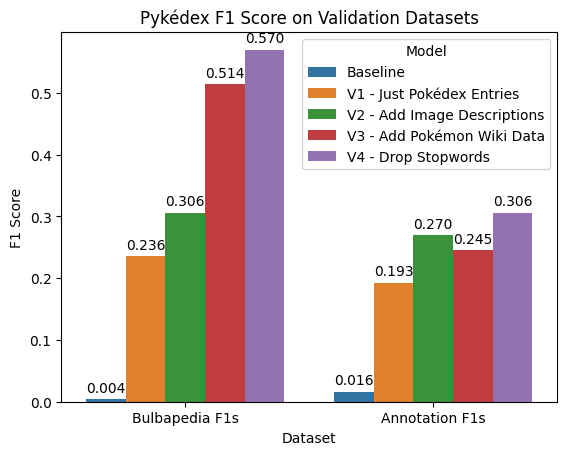

In [370]:

ax = sns.barplot(x='Dataset',
            y='value',
            hue='Model'
            , data=pd.melt(f1_df, id_vars = ['Model'], var_name = 'Dataset'))
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f', padding=3)
plt.title('Pykédex F1 Score on Validation Datasets')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.show()

Is there a difference in the prompt length for the model correctly vs incorrectly guessing the Pokémon?

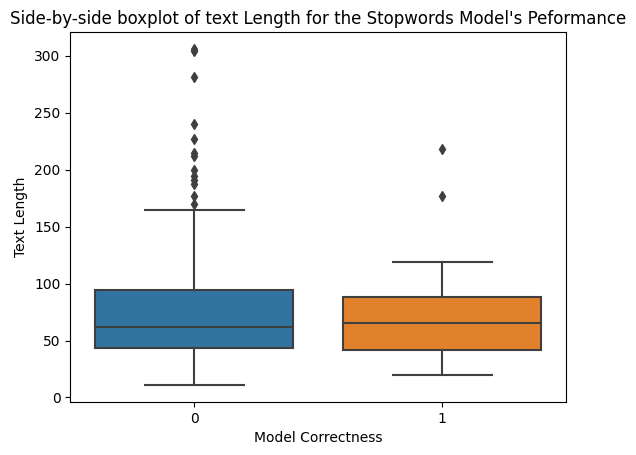

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
annots = pd.read_csv('annotations.csv').drop(columns = ['Unnamed: 0'])
annots['arglength'] = annots.Annotation.apply(lambda x: len(x))
sns.boxplot(data = annots, x = 'V4', y = 'arglength')
plt.title("Side-by-side boxplot of text Length for the Stopwords Model's Peformance")
plt.ylabel('Text Length')
plt.xlabel("Model Correctness")
plt.show()
